In [65]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Encoder
We have a RNN where
$$
h_t = \text{RNN}(x_t, h_{t-1})
$$
The encoder converts its hidden states $h$ to context vectors $c$ from all timesteps
$$
c = \text{Encoder}(\{h_1, h_2, \ldots, h_T\})
$$

In [66]:
from naml.modules import torch, nn, optim, F
from naml.modules.sequence import Seq2SeqEncoder

encoder = Seq2SeqEncoder(10,8,16,2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
H = encoder.begin_state(X.device, batch_size=4)
Y, H = encoder(X)
Y.shape, H.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## Decoder
The decoder is another RNN that takes hidden state $h_{t-1}$, output $y_{t-1}$, and context vector $c$ to produce hidden state $h_t$ and output $y_t$
$$
h_t = \text{RNN}(y_{t-1}, h_{t-1}, c)
$$

In [67]:
from naml.modules.sequence import Seq2SeqDecoder

encoder = Seq2SeqEncoder(10,8,16,2)
encoder.eval()
decoder = Seq2SeqDecoder(10,8,16,2)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)

Y, H = encoder(X)
Y, H = decoder(X, H)
Y.shape, H.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## CEL with masking
Masking would simply ignore loss at reserved tokens - defined by sequence lengths

In [68]:
from naml.modules import torch, nn
from naml.sequence import zero_one_mask
logits = torch.ones((3, 4, 10)) # batch, step, vocab -> logit for index i
target = torch.ones((3, 4)).long() # batch, step -> vocab index
loss = nn.CrossEntropyLoss(reduction='none')

M_l = loss(logits.permute(0, 2, 1), target)
print(M_l)
lens = torch.tensor([4, 2, 0])
mask = zero_one_mask(M_l.shape, lens)
M_l = M_l * mask
print(M_l)
print(M_l.mean(dim = 1))

# With naml module
from naml.modules.sequence import CELWithLengthMask
loss = CELWithLengthMask()
M_l = loss(logits, target, lens)
print(M_l)

tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026]])
tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])
tensor([2.3026, 1.1513, 0.0000])
tensor([2.3026, 1.1513, 0.0000])


## Training
We need to append `<bos>` tokens to the beginning of the target sequences. Since it's `<pad>` tokens that are masked, we don't need to worry about `<eos>` tokens.

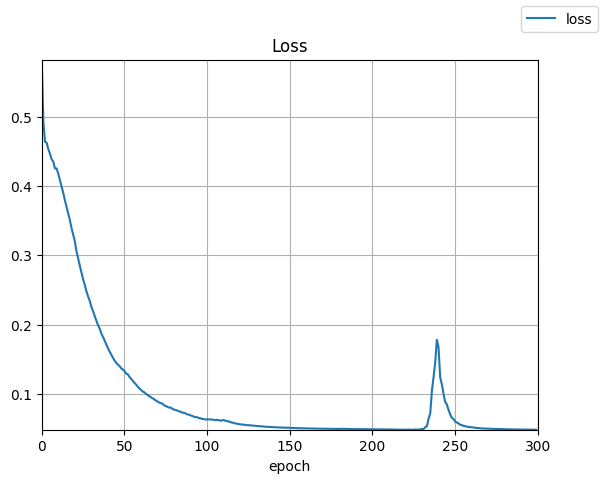

Loss:   0%|          | 0/300 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [69]:
from naml.modules import List
from naml.text import Vocabulary, pair_vocab_batch_sample_iter
from naml.util import run_epochs, ret_accumlated_loss
from naml.modules.sequence import EncoderDecoder
def train(
        net : EncoderDecoder, lr, epochs, 
        src_vocab : Vocabulary, tgt_vocab : Vocabulary, 
        src_words : List[List[str]], tgt_words : List[List[str]],
        batch_size: int, num_steps: int
    ):
    net.train() # Train mode
    # TODO: Xavier weight init
    opt = optim.Adam(net.parameters(), lr=lr) # XXX: Different optimizer?
    loss = CELWithLengthMask()
    data_iter = list(pair_vocab_batch_sample_iter(src_vocab, tgt_vocab, src_words, tgt_words,batch_size,num_steps))
    @run_epochs("Loss")
    def run_epoch():
        ret_loss = ret_accumlated_loss()
        opt.zero_grad()
        for x, x_len, y, y_len in data_iter:
            bos = torch.Tensor(tgt_vocab.to_indices(["<bos>"] * y.shape[0])).long().reshape(-1,1)
            y_in = torch.cat([bos, y[:, :-1]], 1) # XXX: Can we do this in data_iter instead?
            y_hat, _ = net.forward(x, y_in)
            l = loss.forward(y_hat, y, y_len)
            l.sum().backward()            
            # TODO: Grad clipping
            opt.step()
            ret_loss.update(l.sum().detach(), y_len.sum())
        return ret_loss
    run_epoch(epochs)

# TODO: Dropout
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

from naml.text import flatten
from naml.dataset import Datasets
from naml.dataset.nmt import load_nmt
datasets = Datasets("~/naml-data")
src_words, target_words = load_nmt(datasets, 'fra', 'eng', max_examples=500)

src_vocab, tgt_vocab = Vocabulary(flatten(src_words)), Vocabulary(flatten(target_words))
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers)
net = EncoderDecoder(encoder, decoder)
train(net, lr, num_epochs, src_vocab, tgt_vocab, src_words, target_words, batch_size, num_steps)


## Prediction
We need to predict until `<eos>` token is generated - which is not in the target sequences.

In [ ]:
from naml.dataset.nmt import nmt_tokenizer

def predict(net : EncoderDecoder, src_sentence : str, src_vocab : Vocabulary, tgt_vocab : Vocabulary, num_steps : int):
    net.eval()
    src_tokens = nmt_tokenizer(src_sentence.lower()) + ['<eos>']    
    src_tokens = src_vocab.to_indices(src_tokens)
    # src_lens = torch.Tensor([len(src_tokens)])
    src_tokens = src_vocab.truncate_pad(src_tokens, num_steps).long()
    
    X_enc = src_tokens.unsqueeze(0) # Only one batch -> [1, num_steps]
    Y_enc, H_enc = net.encoder(X_enc)
    H = H_enc

    X_dec = torch.Tensor(tgt_vocab.to_indices(["<bos>"])).long().unsqueeze(0)    
    for step in range(num_steps):
        Y_hat, H = net.decoder(X_dec, H)
        X_dec = Y_hat.argmax(dim=2)
        pred = X_dec.squeeze(0).long().item()
        print(tgt_vocab.to_tokens([pred])[0], end=' ')
    print()

predict(net, "go.", src_vocab, tgt_vocab, num_steps)
predict(net, "i lost.", src_vocab, tgt_vocab, num_steps)
predict(net, "he's calm.", src_vocab, tgt_vocab, num_steps)
predict(net, "i'm home.", src_vocab, tgt_vocab, num_steps)
# oh no why is it so bad
# TODO: BLEU

tokens ['go', '.', '<eos>']
en est . . . ! ! ! ! ! 
tokens ['i', 'lost', '.', '<eos>']
j ' ai perdu . de là . . ! 
tokens ['he', "'", 's', 'calm', '.', '<eos>']
serrez-moi dans vos bras ! ! ! ! ! ! 
tokens ['i', "'", 'm', 'home', '.', '<eos>']
je pue . . ' parti . ' ici . 
